# Introduction to Time Series Analysis for Hydrologic Data

This lesson was adapted from educational material written by [Dr. Kateri Salk](https://www.hydroshare.org/user/4912/) for her Fall 2019 Hydrologic Data Analysis course at Duke University. This is the first part of a two-part exercise focusing on time series analysis. 

## Introduction
Time series are a special class of dataset, where a response variable is tracked over time. The frequency of measurement and the timespan of the dataset can vary widely. At its most simple, a time series model includes an explanatory time component and a response variable. Mixed models can include additional explanatory variables (check out the `nlme` and `lme4` R packages). We will be covering a few simple applications of time series analysis in these lessons.

### Opportunities

Analysis of time series presents several opportunities. In aquatic sciences, some of the most common questions we can answer with time series modeling are:

* Has there been an increasing or decreasing **trend** in the response variable over time?
* Can we **forecast** conditions in the future?


### Challenges

Time series datasets come with several caveats, which need to be addressed in order to effectively model the system. A few common challenges that arise (and can occur together within a single dataset) are: 

* **Autocorrelation**: Data points are not independent from one another (i.e., the measurement at a given time point is dependent on previous time point(s)).

* **Data gaps**: Data are not collected at regular intervals, necessitating *interpolation* between measurements.
There are often gaps between monitoring periods. For many time series analyses, we need equally spaced points. 

* **Seasonality**: Cyclic patterns in variables occur at regular intervals, impeding clear interpretation of a monotonic (unidirectional) trend. Ex. We can assume that summer temperatures are higher.

* **Heteroscedasticity**: The variance of the time series is not constant over time.

* **Covariance**: the covariance of the time series is not constant over time.
Many of these models assume that the variance and covariance are similar over the time-->heteroschedasticity. 

## Learning Objectives

After successfully completing this notebook, you will be able to:
1. Choose appropriate time series analyses for trend detection and forecasting
2. Discuss the influence of seasonality on time series analysis
3. Interpret and communicate results of time series analyses 

## Requirements to Complete Lesson 

### Packages
This lesson requires the installation of the following R packages to run the provided script:
- `ggplot2`- Version 3.3.3. Creates elegant data visualisations using the Grammar of Graphics.
- `tidyverse`- Version 1.3.0. A collection of R packages designed for data science.
- `lubridate`- Version 1.7.9. Functions for working with dates/times.
- `scales`-Version 1.1.1. Graphical scales provide methods for automatically determining breaks and labels for axes and legends.
- `dataRetrival`-Version 2.7.6. Retrieval Functions for USGS and EPA Hydrologic and Water Quality Data.
- `stats`-Version 4.0.3. This package contains functions for statistical calculations and random number generation.
- `stlplus`-Version 0.5.1. Decompose a time series into seasonal, trend, and remainder components using an implementation of Seasonal Decomposition of Time Series by Loess (STL) that provides several enhancements over the STL method in the stats package. 

### Data and Code 

This lesson will import daily discharge data for Clear Creek near Denver, Colorado for the entire period of record using the `dataRetrieval` package. The package was created to make querying and downloading hydrologic data from the USGS National Water Information System (NWIS) and the multi-agency database, Water Quality Portal (WQP) easier. NWIS contains streamflow, peak flow, rating curves, groundwater, and water quality data data collected by or for the USGS. WQP only contains water quality data.

It should be noted that the databases are not static as data is constantly being added.  For more in-depth information on the `dataRetrieval` package, please visit https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html. 

The code provided in this resource was developed using R version 3.6.1. 

### Set Working Directory 

In R, the working directory is the directory where R starts when looking for any file to open (as directed by a file path) and where it saves any output. This lesson assumes that you have set your working directory to the folder location of the downloaded and unzipped data subsets.

### Load packages and set ggplot theme

In [1]:
options(warn=-1)

library(ggplot2)
library(tidyverse)
library(lubridate)
library(scales)
library(dataRetrieval)
library(stats)
library(stlplus)

theme_set(theme_gray()) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✓ tibble  3.0.5     ✓ dplyr   1.0.3
✓ tidyr   1.1.2     ✓ stringr 1.4.0
✓ readr   1.4.0     ✓ forcats 0.5.0
✓ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




## Import Daily Discharge Data from Clear Creek 

## `readNWISdv`
Use the `readNWISdv` function to import daily discharge data from the NWIS web service. You can access the complete list of NWIS parameter codes here: https://nwis.waterdata.usgs.gov/nwis/pmcodes. 

In [4]:
ClearCreekDischarge <- readNWISdv(siteNumbers = "06719505",
                     parameterCd = "00060", #discharge (ft3/s)
                     startDate = "",
                     endDate = "")

names(ClearCreekDischarge)[4:5] <- c("Discharge", "Approval.Code")#change last two column headers

head(ClearCreekDischarge)


agency_cd site_no  Date       Discharge Approval.Code
1 USGS      06719505 1974-10-01 89        A            
2 USGS      06719505 1974-10-02 94        A            
3 USGS      06719505 1974-10-03 91        A            
4 USGS      06719505 1974-10-04 89        A            
5 USGS      06719505 1974-10-05 91        A            
6 USGS      06719505 1974-10-06 93        A

## Plot Discharge over Time

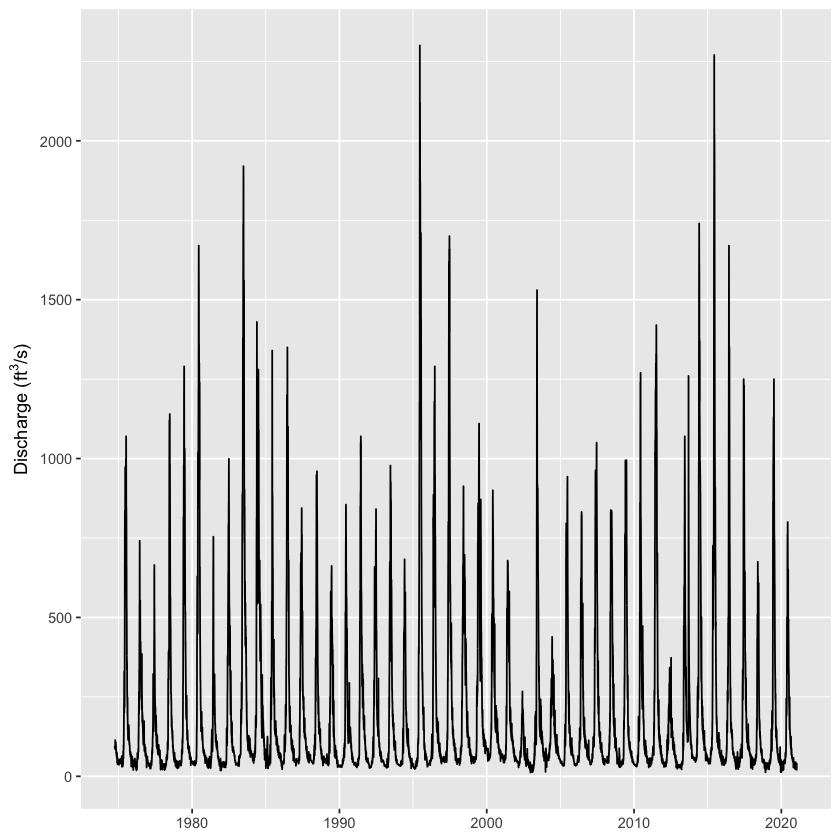

In [63]:
ClearCreekPlot <- 
  ggplot(ClearCreekDischarge, aes(x = Date, y = Discharge)) +
  geom_line() +
  labs(x = "", y = expression("Discharge (ft"^3*"/s)")) + 
  theme(plot.title = element_text(margin = margin(b = -10), size = 12), 
       axis.title.x = element_blank())
print(ClearCreekPlot)


## Decomposing a Time Series Dataset

A given time series can be made up of several component series: 

1. A **seasonal** component, which repeats over a fixed known period (e.g., seasons of the year, months, days of the week, hour of the day). 

2. A **trend** component, which quantifies the upward or downward progression over time. The trend component of a time series does not have to be monotonic.
This doesn't need to be unidirectional: it could go up for a little bit, and go down again.

3. An **error** or **random** component, which makes up the remainder of the time series after other components have been accounted for. This component reflects the noise in the dataset. 
Anything not explained by the seasons will be classified as error-we'll alwys have randomness in our data incorporated into our model. 

4. (optional) A **cyclical** component, which repeats over periods greater than the seasonal component. A good example of this in hydrologic data is El Niño Southern Oscillation (ENSO) cycles, which occur over a period of 2-8 years.

We first need to turn the discharge data into a time series object in R. This is done using the `ts` function. Notice we can only specify one column of data and need to specify the period at which the data are sampled. The resulting time series object cannot be viewed like a regular data frame.

### Determine number of observations in dataset

In [64]:
nobsCC<-nrow(ClearCreekDischarge)
nobsCC

[1] 16911

### Create a vector for the number of observations

In [65]:
tCC<-1:nobsCC

## Create a time series object 

## `ts` 
Use the `ts` function to create time series objects. 

**timeseries.object.name <-  ts(data, start, end, frequency)**

"data" is a vector or matrix containing the values used in the time series.

"start" specifies the start time for the first observation in time series.

"end" specifies the end time for the last observation in time series. This is optional. 

"frequency" specifies the number of observations per unit time.

In [66]:
ClearCreek_ts <- ts(ClearCreekDischarge[tCC,4], frequency = 365,  start = c(1974, 10))
ClearCreek_ts

A Time Series:
    [1]   89.0   94.0   91.0   89.0   91.0   93.0   91.0   89.0   86.0   88.0
   [11]   91.0  114.0  103.0  107.0   98.0   93.0   91.0   91.0   93.0   91.0
   [21]   86.0   91.0   94.0  101.0  107.0   98.0   93.0   89.0   91.0   98.0
   [31]   81.0   80.0   84.0   88.0   78.0   73.0   75.0   73.0   72.0   78.0
   [41]   73.0   67.0   66.0   70.0   67.0   67.0   66.0   62.0   67.0   63.0
   [51]   59.0   73.0   75.0   72.0   63.0   70.0   72.0   52.0   47.0   43.0
   [61]   43.0   52.0   55.0   58.0   60.0   60.0   58.0   51.0   38.0   40.0
   [71]   47.0   53.0   55.0   43.0   41.0   43.0   45.0   47.0   45.0   43.0
   [81]   43.0   45.0   45.0   42.0   39.0   42.0   45.0   47.0   49.0   47.0
   [91]   45.0   43.0   45.0   48.0   46.0   46.0   46.0   48.0   48.0   46.0
  [101]   46.0   43.0   40.0   36.0   39.0   42.0   44.0   46.0   48.0   50.0
  [111]   50.0   52.0   52.0   45.0   46.0   48.0   48.0   46.0   46.0   44.0
  [121]   42.0   44.0   44.0   42.0   42.0   44.0   42.0   40.0   40.0   44.0
  [131]   48.0   54.0   52.0   52.0   50.0   50.0   48.0   50.0   48.0   50.0
  [141]   46.0   46.0   51.0   48.0   44.0   50.0   55.0   52.0   48.0   46.0
  [151]   48.0   50.0   53.0   50.0   46.0   46.0   45.0   41.0   45.0   46.0
  [161]   44.0   41.0   41.0   46.0   47.0   48.0   46.0   48.0   44.0   53.0
  [171]   56.0   62.0   60.0   48.0   43.0   49.0   54.0   49.0   30.0   53.0
  [181]   59.0   64.0   47.0   42.0   45.0   54.0   56.0   62.0   63.0   38.0
  [191]   34.0   38.0   33.0   31.0   32.0   32.0   31.0   34.0   39.0   47.0
  [201]   40.0   39.0   38.0   39.0   46.0   45.0   51.0   66.0   79.0   63.0
  [211]   58.0   56.0   58.0   59.0   58.0   65.0   93.0   98.0   90.0   86.0
  [221]   84.0   91.0  104.0  129.0  134.0  146.0  181.0  186.0  207.0  220.0
  [231]  229.0  251.0  291.0  330.0  243.0  201.0  212.0  236.0  275.0  319.0
  [241]  285.0  227.0  232.0  218.0  238.0  322.0  417.0  502.0  659.0  761.0
  [251]  836.0  771.0  722.0  616.0  583.0  575.0  650.0  764.0  973.0  910.0
  [261]  881.0  916.0  841.0  859.0  789.0  781.0  877.0  962.0  904.0  877.0
  [271]  914.0  877.0  914.0  924.0  942.0  990.0 1000.0  971.0  895.0  877.0
  [281]  933.0 1070.0 1000.0  962.0  901.0  811.0  771.0  846.0  804.0  816.0
  [291]  701.0  635.0  662.0  615.0  531.0  529.0  526.0  473.0  432.0  379.0
  [301]  337.0  348.0  362.0  358.0  357.0  319.0  280.0  260.0  251.0  248.0
  [311]  246.0  238.0  234.0  217.0  194.0  191.0  249.0  233.0  195.0  175.0
  [321]  173.0  158.0  152.0  146.0  158.0  161.0  137.0  126.0  117.0  121.0
  [331]  152.0  152.0  138.0  126.0  128.0  123.0  114.0  125.0  126.0  125.0
  [341]  121.0  119.0  118.0  120.0  158.0  142.0  140.0  156.0  161.0  151.0
  [351]  145.0  149.0  149.0  138.0  124.0  120.0  119.0  115.0  107.0  101.0
  [361]  101.0  106.0  105.0  105.0  105.0  103.0  101.0  100.0   98.0   94.0
  [371]   93.0   96.0   86.0   78.0   78.0   80.0   76.0   75.0   73.0   69.0
  [381]   76.0   78.0   74.0   76.0   71.0   69.0   69.0   71.0   68.0   62.0
  [391]   74.0   76.0   76.0   71.0   68.0   69.0   69.0   65.0   65.0   63.0
  [401]   65.0   68.0   66.0   65.0   60.0   50.0   58.0   31.0   52.0   66.0
  [411]   57.0   54.0   52.0   50.0   49.0   38.0   43.0   45.0   47.0   47.0
  [421]   47.0   45.0   47.0   47.0   47.0   44.0   48.0   55.0   57.0   61.0
  [431]   63.0   59.0   60.0   58.0   58.0   53.0   51.0   52.0   48.0   48.0
  [441]   34.0   32.0   41.0   28.0   35.0   45.0   50.0   50.0   50.0   45.0
  [451]   45.0   48.0   50.0   48.0   46.0   48.0   45.0   30.0   20.0   35.0
  [461]   45.0   47.0   47.0   40.0   35.0   40.0   40.0   40.0   40.0   40.0
  [471]   35.0   40.0   40.0   45.0   48.0   46.0   44.0   43.0   51.0   48.0
  [481]   50.0   45.0   42.0   45.0   45.0   50.0   48.0   48.0   45.0   44.0
  [491]   44.0   42.0   34.0   38.0   40.0   45.0   56.0   52.0   49.0   47.0
  [501]   52.0   49.0   47.0   45.0   42.0   36.0   42.0   40.0   31.0   30.0
  [511]

## Decompose the Time Series

## `stlplus` 
Use the `stlplus` function to decompose the time series object into its component parts. We must specify that the window for seasonal extraction is either "periodic" or a specific number of at least 7. The decomposition proceeds through a loess (locally estimated scatterplot smoothing) function.

In [67]:
ClearCreek_Decomposed <- stlplus(ClearCreek_ts, s.window = "periodic")

## Visualize the decomposed time series

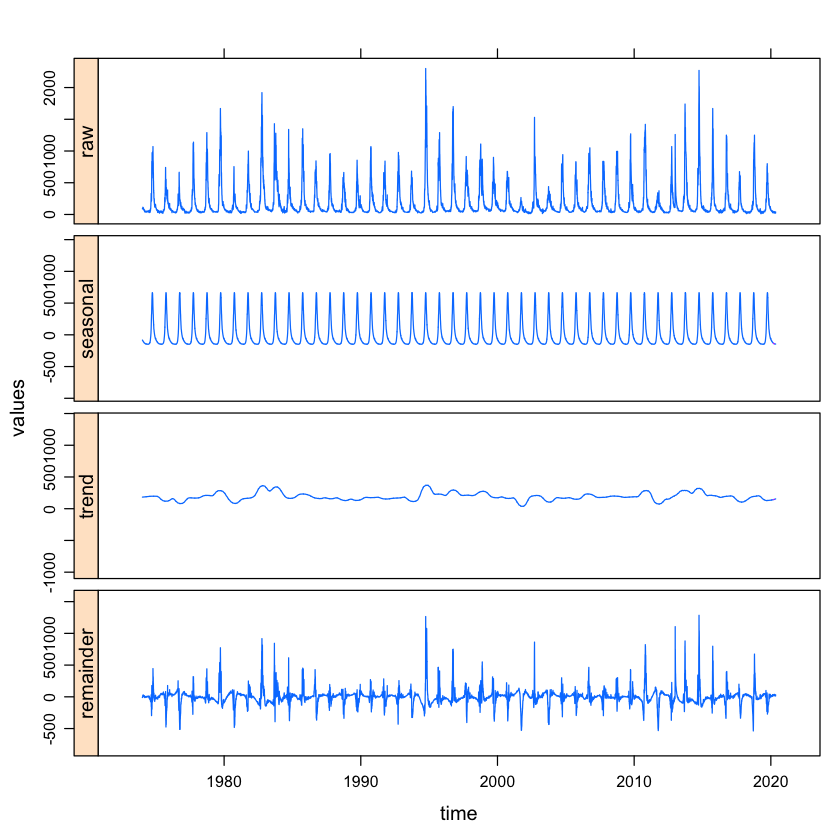

In [68]:
plot(ClearCreek_Decomposed)

### Extract components from decomposed time series and turn them into data frames

In [69]:
ClearCreek_Components <- as.data.frame(ClearCreek_Decomposed$data[,1:4]) #Pull in the "data" list to create a dataframe

ClearCreek_Components <- mutate(ClearCreek_Components,
                      Observed = ClearCreekDischarge$Discharge,     
                      Date = ClearCreekDischarge$Date) #add in date so we can look at these over time

## Visualize the trend component over time

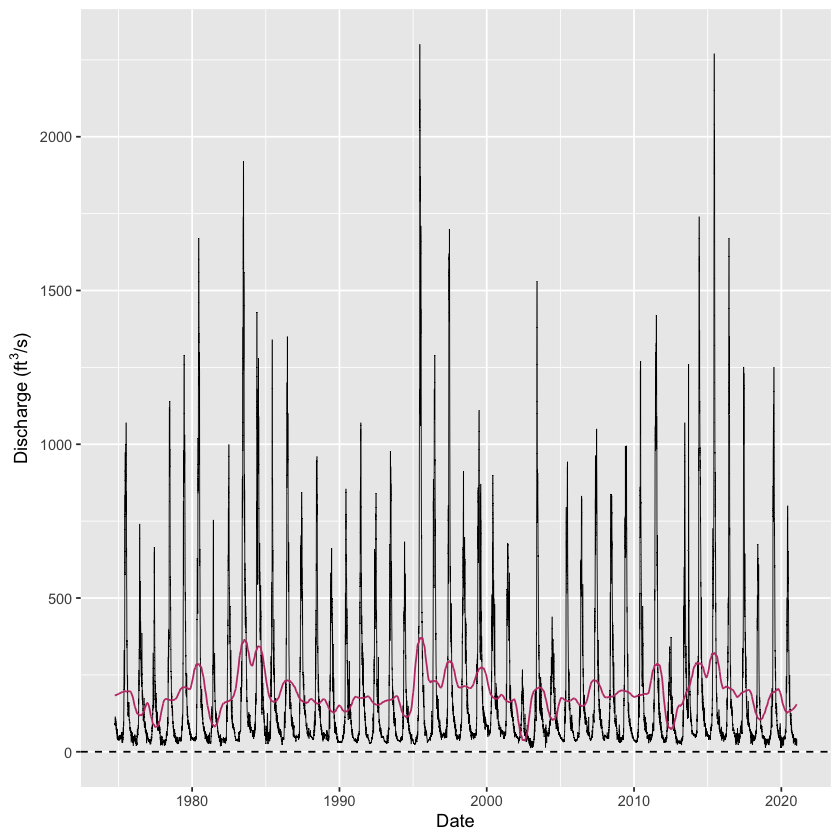

In [70]:
ggplot(ClearCreek_Components) +
  geom_line(aes(y = Observed, x = Date),  size = 0.25) +
  geom_line(aes(y = trend, x = Date), color = "#c13d75ff") +
  geom_hline(yintercept = 0, lty = 2) +
  ylab(expression("Discharge (ft"^3*"/s)"))

## Visualize the seasonal component over time

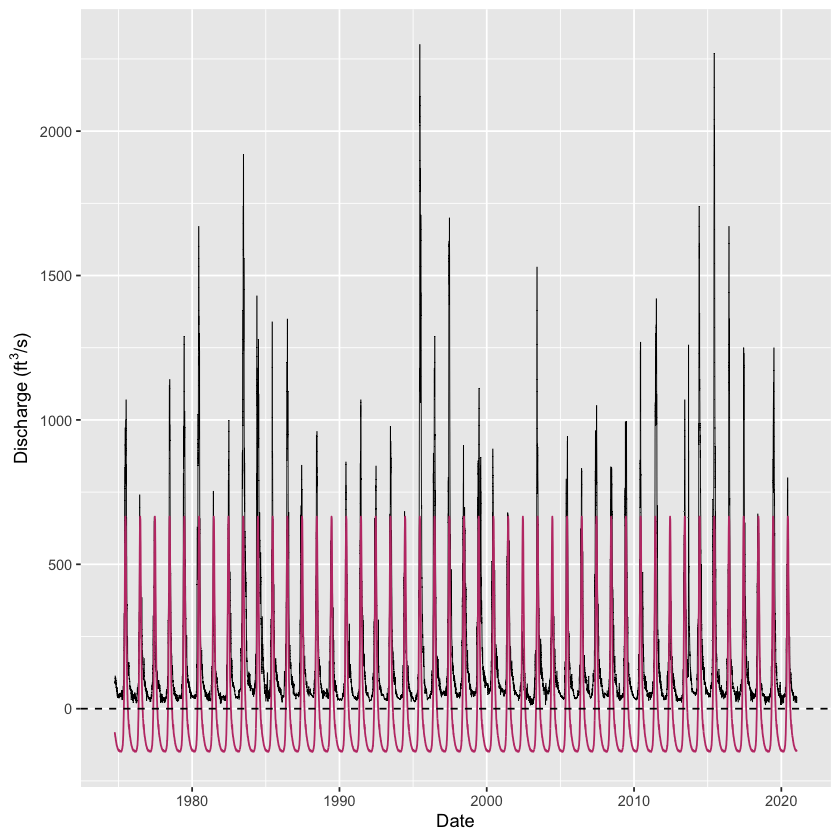

In [71]:
ggplot(ClearCreek_Components) +
  geom_line(aes(y = Observed, x = Date),  size = 0.25) +
  geom_line(aes(y = seasonal, x = Date), color = "#c13d75ff") +
  geom_hline(yintercept = 0, lty = 2) +
  ylab(expression("Discharge (ft"^3*"/s)"))

Note that the decomposition can yield negative values when we apply a seasonal adjustment or a trend adjustment to the data. The decomposition is not constrained by a lower bound of zero as discharge is in real life. Make sure to interpret with caution!

## Visualize the remainder component over time

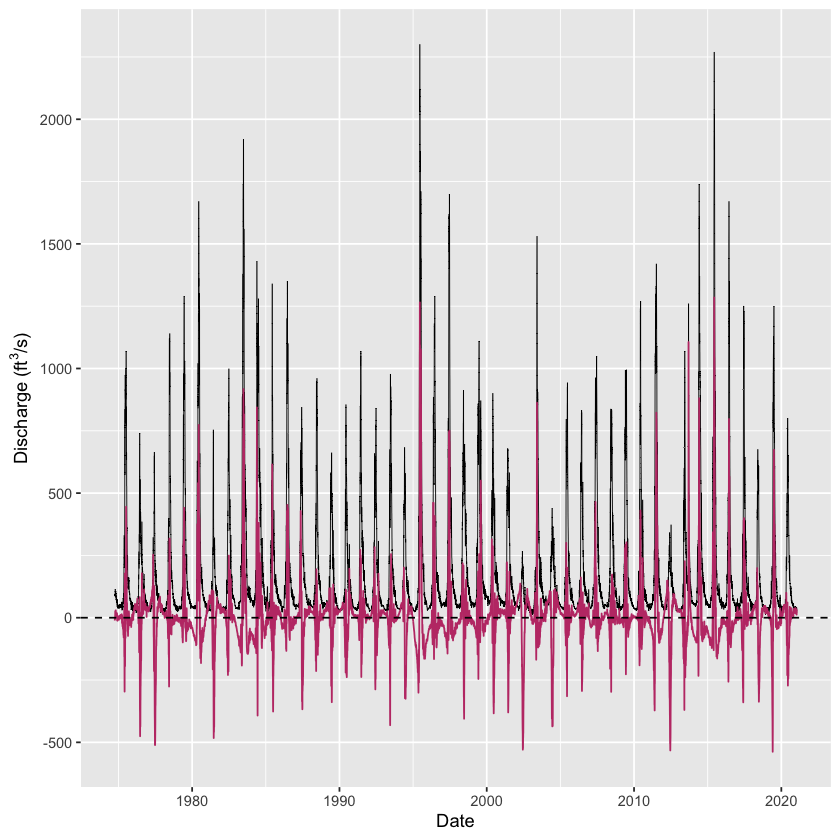

In [72]:
ggplot(ClearCreek_Components) +
  geom_line(aes(y = Observed, x = Date),  size = 0.25) +
  geom_line(aes(y = remainder, x = Date), color = "#c13d75ff") +
  geom_hline(yintercept = 0, lty = 2) +
  ylab(expression("Discharge (ft"^3*"/s)"))